In [4]:
import pandas as pd

# Load the data
df = pd.read_excel('/Users/jinnanut/Library/Mobile Documents/com~apple~CloudDocs/NUT/Exeter University/Master/Term 3/BEMM466 Business Project/Dissertation/Data/AmazonData.xlsx')
df['date'] = pd.to_datetime(df['date'])

# Get unique categories
categories = df['category'].unique()

# Create a dictionary to hold results
category_data = {}

# Define a 5-week test window
test_window = pd.Timedelta(weeks=5)

# Loop over each category
for cat in categories:
    print(f"\nProcessing category: {cat}")
    
    # Filter and resample weekly
    df_cat = df[df["category"] == cat].copy()
    df_cat = df_cat.set_index('date').sort_index()
    df_cat = df_cat[["quantity"]].resample('W').sum()
    
    # Initialize storage
    category_data[cat] = {"full": df_cat}
    
    # Walk-forward parameters
    start_train = pd.Timestamp("2019-01-01")
    end_of_data = df_cat.index.max()

    split_idx = 1
    # Start testing after 1 year of training data
    test_start = start_train + pd.Timedelta(weeks=52)
    test_end = test_start + test_window - pd.Timedelta(days=1)

    while test_end <= end_of_data:
        train_start = start_train
        train_end = test_start - pd.Timedelta(days=1)

        train_data = df_cat.loc[train_start:train_end]
        test_data = df_cat.loc[test_start:test_end]

        if train_data.empty or test_data.empty:
            print(f"  Skipping split {split_idx}: empty train or test")
        else:
            category_data[cat][f"train_{split_idx}"] = train_data
            category_data[cat][f"test_{split_idx}"] = test_data
            print(f"  Split {split_idx}: "
                  f"Train = {train_start.date()} to {train_end.date()}, "
                  f"Test = {test_start.date()} to {test_end.date()}")

        # Move test window forward by 5 weeks
        test_start += test_window
        test_end = test_start + test_window - pd.Timedelta(days=1)
        split_idx += 1

# Preview one category’s data
sample_cat = categories[0]
print(f"\nPreview for category '{sample_cat}':")
print(category_data[sample_cat]["full"].head())



Processing category: Appliances
  Skipping split 1: empty train or test
  Skipping split 2: empty train or test
  Skipping split 3: empty train or test
  Skipping split 4: empty train or test
  Skipping split 5: empty train or test
  Skipping split 6: empty train or test
  Skipping split 7: empty train or test
  Skipping split 8: empty train or test
  Split 9: Train = 2019-01-01 to 2020-10-05, Test = 2020-10-06 to 2020-11-09
  Split 10: Train = 2019-01-01 to 2020-11-09, Test = 2020-11-10 to 2020-12-14
  Split 11: Train = 2019-01-01 to 2020-12-14, Test = 2020-12-15 to 2021-01-18
  Split 12: Train = 2019-01-01 to 2021-01-18, Test = 2021-01-19 to 2021-02-22
  Split 13: Train = 2019-01-01 to 2021-02-22, Test = 2021-02-23 to 2021-03-29
  Split 14: Train = 2019-01-01 to 2021-03-29, Test = 2021-03-30 to 2021-05-03
  Split 15: Train = 2019-01-01 to 2021-05-03, Test = 2021-05-04 to 2021-06-07
  Split 16: Train = 2019-01-01 to 2021-06-07, Test = 2021-06-08 to 2021-07-12
  Split 17: Train = 2019

# Applying Machine Learning with Monte Carlo Simulation with Case Study

### Import Essential Tools

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### 1. Find Seasonal Index & Deseasonalize

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create dictionary to store seasonality results
seasonality_results = {}

for cat in categories:
    print(f"\nProcessing seasonal index for: {cat}")

    if cat not in category_data:
        print(f"  Skipping {cat}: no data.")
        continue

    seasonality_results[cat] = {}

    for key in category_data[cat]:
        if not key.startswith("train_"):
            continue

        train_df = category_data[cat][key].copy()

        if train_df.empty:
            print(f"  Skipping {cat} - {key}: empty train data.")
            continue

        # === Step 1: Extract ISO week number (1–52) ===
        train_df["week"] = train_df.index.isocalendar().week
        train_df["year"] = train_df.index.isocalendar().year

        # === Step 2: Compute weekly seasonal index (smoothed) ===
        overall_avg = train_df["quantity"].mean()
        weekly_avg = train_df.groupby("week")["quantity"].mean()

        # Smooth with rolling mean (handles noise better)
        weekly_avg_smooth = weekly_avg.rolling(3, center=True, min_periods=1).mean()

        # Normalize so seasonal index has mean = 1
        seasonal_index = weekly_avg_smooth / weekly_avg_smooth.mean()

        # Debug plot (optional: pick one case to visualize)
        if cat == categories[0] and key == "train_1":
            seasonal_index.plot(title=f"Smoothed Seasonal Index - {cat} - {key}")
            plt.grid(True)
            plt.show()

        # === Step 3: Map seasonal index back to train data ===
        train_df["seasonal_index"] = train_df["week"].map(seasonal_index)

        # === Step 4: Deseasonalize ===
        train_df["deseasonalized"] = (
            train_df["quantity"] / train_df["seasonal_index"].replace(0, np.nan)
        )
        train_df.dropna(subset=["deseasonalized"], inplace=True)

        # === Save results ===
        seasonality_results[cat][key] = {
            "seasonal_index": seasonal_index,
            "deseasonalized_train": train_df
        }

        print(f"  Done {cat} - {key}: {len(train_df)} weekly points deseasonalized.")



Processing seasonal index for: Appliances
  Done Appliances - train_9: 1 weekly points deseasonalized.
  Done Appliances - train_10: 6 weekly points deseasonalized.
  Done Appliances - train_11: 11 weekly points deseasonalized.
  Done Appliances - train_12: 16 weekly points deseasonalized.
  Done Appliances - train_13: 21 weekly points deseasonalized.
  Done Appliances - train_14: 26 weekly points deseasonalized.
  Done Appliances - train_15: 31 weekly points deseasonalized.
  Done Appliances - train_16: 36 weekly points deseasonalized.
  Done Appliances - train_17: 41 weekly points deseasonalized.
  Done Appliances - train_18: 46 weekly points deseasonalized.

Processing seasonal index for: Beauty & Grooming
  Done Beauty & Grooming - train_9: 1 weekly points deseasonalized.
  Done Beauty & Grooming - train_10: 6 weekly points deseasonalized.
  Done Beauty & Grooming - train_11: 11 weekly points deseasonalized.
  Done Beauty & Grooming - train_12: 16 weekly points deseasonalized.
  D

### 2. Fit Trend Models & Select the Best model

In [7]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

trend_results = {}

for cat in seasonality_results:
    print(f"\nFitting candidate models for category: {cat}")
    trend_results[cat] = {}

    for train_key in seasonality_results[cat]:
        if not train_key.startswith("train_"):
            continue

        train_df = seasonality_results[cat][train_key]["deseasonalized_train"].copy()

        if len(train_df) < 10:
            print(f"  Skipping {cat} - {train_key}: too few points ({len(train_df)})")
            continue

        y = train_df["deseasonalized"].values
        X_time = np.arange(len(y)).reshape(-1, 1)

        candidate_models = {}

        # === Linear Regression Trend ===
        lin = LinearRegression()
        lin.fit(X_time, y)
        y_pred_lin = lin.predict(X_time)
        candidate_models["linear"] = {
            "in_sample_pred": y_pred_lin,
            "rmse": mean_squared_error(y, y_pred_lin, squared=False),
            "mae": mean_absolute_error(y, y_pred_lin),
            "model": lin,
            "forecast_func": lambda horizon: lin.predict(np.arange(len(y), len(y)+horizon).reshape(-1, 1))
        }

        # === Polynomial Trend (deg 2) ===
        poly2 = PolynomialFeatures(2)
        X_poly2 = poly2.fit_transform(X_time)
        lin_poly = LinearRegression()
        lin_poly.fit(X_poly2, y)
        y_pred_poly = lin_poly.predict(X_poly2)
        candidate_models["poly2"] = {
            "in_sample_pred": y_pred_poly,
            "rmse": mean_squared_error(y, y_pred_poly, squared=False),
            "mae": mean_absolute_error(y, y_pred_poly),
            "model": lin_poly,
            "transformer": poly2,
            "forecast_func": lambda horizon: lin_poly.predict(poly2.transform(
                np.arange(len(y), len(y)+horizon).reshape(-1, 1)))
        }

        # === Holt-Winters Exponential Smoothing ===
        try:
            hw = ExponentialSmoothing(train_df["deseasonalized"],
                                      trend="add", seasonal=None).fit()
            y_pred_hw = hw.fittedvalues
            candidate_models["holt_winters"] = {
                "in_sample_pred": y_pred_hw.values,
                "rmse": mean_squared_error(y, y_pred_hw, squared=False),
                "mae": mean_absolute_error(y, y_pred_hw),
                "model": hw,
                "forecast_func": lambda horizon: hw.forecast(horizon).values
            }
        except Exception as e:
            print(f"    Holt-Winters failed: {e}")

        # === XGBoost with lag features ===
        train_df["lag_1"] = train_df["deseasonalized"].shift(1)
        train_df["lag_2"] = train_df["deseasonalized"].shift(2)
        train_df.dropna(inplace=True)
        y_ml = train_df["deseasonalized"].values
        X_ml = train_df[["lag_1", "lag_2"]].values

        xgb = XGBRegressor(objective="reg:squarederror", n_estimators=200,
                           learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)
        xgb.fit(X_ml, y_ml)
        y_pred_xgb = xgb.predict(X_ml)

        def xgb_forecast(horizon):
            last_vals = list(train_df["deseasonalized"][-2:])
            forecast_vals = []
            for _ in range(horizon):
                x_next = np.array([last_vals[-1], last_vals[-2]]).reshape(1, -1)
                y_next = xgb.predict(x_next)[0]
                forecast_vals.append(y_next)
                last_vals.append(y_next)
            return np.array(forecast_vals)

        candidate_models["xgboost"] = {
            "in_sample_pred": y_pred_xgb,
            "rmse": mean_squared_error(y_ml, y_pred_xgb, squared=False),
            "mae": mean_absolute_error(y_ml, y_pred_xgb),
            "model": xgb,
            "forecast_func": xgb_forecast
        }

        # === Select best model by RMSE ===
        best_model_name = min(candidate_models, key=lambda k: candidate_models[k]["rmse"])
        best_model = candidate_models[best_model_name]

        forecast_horizon = 5
        forecast_vals = best_model["forecast_func"](forecast_horizon)

        trend_results[cat][train_key] = {
            "best_model": best_model_name,
            "model": best_model["model"],
            "in_sample_pred": best_model["in_sample_pred"],
            "residuals": y[-len(best_model["in_sample_pred"]):] - best_model["in_sample_pred"],
            "forecast": forecast_vals,
            "rmse": best_model["rmse"],
            "mae": best_model["mae"]
        }

        print(f"  {train_key}: Best = {best_model_name}, RMSE = {best_model['rmse']:.2f}, "
              f"MAE = {best_model['mae']:.2f}, Forecast Horizon = {forecast_horizon} weeks")



Fitting candidate models for category: Appliances
  Skipping Appliances - train_9: too few points (1)
  Skipping Appliances - train_10: too few points (6)
  train_11: Best = xgboost, RMSE = 0.04, MAE = 0.03, Forecast Horizon = 5 weeks
  train_12: Best = xgboost, RMSE = 0.38, MAE = 0.30, Forecast Horizon = 5 weeks
  train_13: Best = xgboost, RMSE = 1.80, MAE = 1.41, Forecast Horizon = 5 weeks
  train_14: Best = xgboost, RMSE = 8.87, MAE = 6.78, Forecast Horizon = 5 weeks
  train_15: Best = xgboost, RMSE = 9.63, MAE = 7.74, Forecast Horizon = 5 weeks
  train_16: Best = xgboost, RMSE = 20.75, MAE = 15.86, Forecast Horizon = 5 weeks
  train_17: Best = xgboost, RMSE = 26.53, MAE = 20.88, Forecast Horizon = 5 weeks
  train_18: Best = xgboost, RMSE = 32.24, MAE = 24.41, Forecast Horizon = 5 weeks

Fitting candidate models for category: Beauty & Grooming
  Skipping Beauty & Grooming - train_9: too few points (1)
  Skipping Beauty & Grooming - train_10: too few points (6)
  train_11: Best = xg

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  train_15: Best = xgboost, RMSE = 16.79, MAE = 12.50, Forecast Horizon = 5 weeks
  train_16: Best = xgboost, RMSE = 27.65, MAE = 20.77, Forecast Horizon = 5 weeks
  train_17: Best = xgboost, RMSE = 32.61, MAE = 24.53, Forecast Horizon = 5 weeks
  train_18: Best = xgboost, RMSE = 53.38, MAE = 40.27, Forecast Horizon = 5 weeks

Fitting candidate models for category: Others
  Skipping Others - train_9: too few points (1)
  Skipping Others - train_10: too few points (6)
  train_11: Best = xgboost, RMSE = 0.02, MAE = 0.01, Forecast Horizon = 5 weeks


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  train_12: Best = xgboost, RMSE = 0.20, MAE = 0.16, Forecast Horizon = 5 weeks
  train_13: Best = xgboost, RMSE = 0.54, MAE = 0.44, Forecast Horizon = 5 weeks
  train_14: Best = xgboost, RMSE = 4.15, MAE = 3.09, Forecast Horizon = 5 weeks
  train_15: Best = xgboost, RMSE = 38.80, MAE = 30.60, Forecast Horizon = 5 weeks
  train_16: Best = xgboost, RMSE = 42.64, MAE = 33.41, Forecast Horizon = 5 weeks
  train_17: Best = xgboost, RMSE = 80.84, MAE = 64.05, Forecast Horizon = 5 weeks
  train_18: Best = xgboost, RMSE = 89.96, MAE = 71.64, Forecast Horizon = 5 weeks

Fitting candidate models for category: School & Education
  Skipping School & Education - train_9: too few points (1)
  Skipping School & Education - train_10: too few points (6)
  train_11: Best = xgboost, RMSE = 0.00, MAE = 0.00, Forecast Horizon = 5 weeks
  train_12: Best = xgboost, RMSE = 0.01, MAE = 0.01, Forecast Horizon = 5 weeks


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  train_13: Best = xgboost, RMSE = 0.16, MAE = 0.12, Forecast Horizon = 5 weeks
  train_14: Best = xgboost, RMSE = 0.24, MAE = 0.20, Forecast Horizon = 5 weeks
  train_15: Best = xgboost, RMSE = 0.57, MAE = 0.47, Forecast Horizon = 5 weeks
  train_16: Best = xgboost, RMSE = 0.98, MAE = 0.74, Forecast Horizon = 5 weeks
  train_17: Best = xgboost, RMSE = 1.37, MAE = 1.06, Forecast Horizon = 5 weeks
  train_18: Best = xgboost, RMSE = 1.58, MAE = 1.22, Forecast Horizon = 5 weeks

Fitting candidate models for category: Soghaat
  Skipping Soghaat - train_9: too few points (1)
  Skipping Soghaat - train_10: too few points (6)
  train_11: Best = xgboost, RMSE = 0.03, MAE = 0.02, Forecast Horizon = 5 weeks
  train_12: Best = xgboost, RMSE = 0.18, MAE = 0.15, Forecast Horizon = 5 weeks
  train_13: Best = xgboost, RMSE = 1.00, MAE = 0.76, Forecast Horizon = 5 weeks
  train_14: Best = xgboost, RMSE = 1.58, MAE = 1.29, Forecast Horizon = 5 weeks
  train_15: Best = xgboost, RMSE = 4.65, MAE = 3.82, 

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  train_11: Best = xgboost, RMSE = 0.06, MAE = 0.05, Forecast Horizon = 5 weeks
  train_12: Best = xgboost, RMSE = 1.61, MAE = 1.29, Forecast Horizon = 5 weeks
  train_13: Best = xgboost, RMSE = 1.36, MAE = 1.03, Forecast Horizon = 5 weeks
  train_14: Best = xgboost, RMSE = 5.86, MAE = 4.60, Forecast Horizon = 5 weeks
  train_15: Best = xgboost, RMSE = 8.18, MAE = 6.51, Forecast Horizon = 5 weeks
  train_16: Best = xgboost, RMSE = 7.61, MAE = 6.05, Forecast Horizon = 5 weeks
  train_17: Best = xgboost, RMSE = 20.37, MAE = 16.29, Forecast Horizon = 5 weeks
  train_18: Best = xgboost, RMSE = 31.31, MAE = 24.72, Forecast Horizon = 5 weeks


### 3. Generate Residual-Based Noise for Monte Carlo

In [8]:
import numpy as np

# Create dictionary to store Monte Carlo inputs
montecarlo_inputs = {}

# Parameters
n_simulations = 1000
forecast_len = 5
block_size = 3  # block bootstrap length

for cat in trend_results:
    print(f"\nGenerating improved Monte Carlo inputs for category: {cat}")
    montecarlo_inputs[cat] = {}

    for train_key in trend_results[cat]:
        if train_key not in seasonality_results[cat]:
            print(f"  Skipping {train_key}: missing seasonality data.")
            continue

        residuals = trend_results[cat][train_key]["residuals"]
        base_forecast = trend_results[cat][train_key]["forecast"]

        if len(residuals) < 10:
            print(f"  Skipping {train_key}: too few residuals")
            continue

        # === Step 1: Clean residuals (remove >3 std outliers)
        resid_mean, resid_std = residuals.mean(), residuals.std()
        cleaned_resid = residuals[np.abs(residuals - resid_mean) < 3 * resid_std]

        # === Step 2: Block bootstrap
        blocks = []
        for _ in range(n_simulations):
            resampled = []
            while len(resampled) < forecast_len:
                start = np.random.randint(0, len(cleaned_resid) - block_size + 1)
                block = cleaned_resid[start:start + block_size]
                resampled.extend(block)
            blocks.append(resampled[:forecast_len])
        boot_noise = np.array(blocks).T  # shape (forecast_len, n_simulations)

        # === Step 3: Optionally scale noise by forecast magnitude
        forecast_scale = np.maximum(base_forecast, 1e-3)  # avoid zero-div
        scaled_noise = boot_noise * (forecast_scale.mean() / np.std(cleaned_resid))

        # === Step 4: Store
        montecarlo_inputs[cat][train_key] = {
            "bootstrapped_noise": scaled_noise,
            "base_forecast": base_forecast,
            "residuals": cleaned_resid
        }

        print(f"  {train_key}: residuals used = {len(cleaned_resid)}, "
              f"noise shape = {scaled_noise.shape}")



Generating improved Monte Carlo inputs for category: Appliances
  Skipping train_11: too few residuals
  train_12: residuals used = 14, noise shape = (5, 1000)
  train_13: residuals used = 19, noise shape = (5, 1000)
  train_14: residuals used = 24, noise shape = (5, 1000)
  train_15: residuals used = 29, noise shape = (5, 1000)
  train_16: residuals used = 34, noise shape = (5, 1000)
  train_17: residuals used = 39, noise shape = (5, 1000)
  train_18: residuals used = 44, noise shape = (5, 1000)

Generating improved Monte Carlo inputs for category: Beauty & Grooming
  Skipping train_11: too few residuals
  train_12: residuals used = 14, noise shape = (5, 1000)
  train_13: residuals used = 19, noise shape = (5, 1000)
  train_14: residuals used = 24, noise shape = (5, 1000)
  train_15: residuals used = 29, noise shape = (5, 1000)
  train_16: residuals used = 34, noise shape = (5, 1000)
  train_17: residuals used = 39, noise shape = (5, 1000)
  train_18: residuals used = 44, noise shape

### 4. Reintroduce Seasonality

In [9]:
import numpy as np

# Create a dictionary to store simulation results
simulated_demands = {}

for cat in trend_results:
    print(f"\nReintroducing seasonality for category: {cat}")
    simulated_demands[cat] = {}

    for train_key in trend_results[cat]:
        # Ensure matching seasonal + simulation input exists
        if train_key not in seasonality_results[cat] or train_key not in montecarlo_inputs[cat]:
            print(f"  Skipping {train_key}: missing seasonality or simulation input")
            continue

        # Fetch base forecast and bootstrapped noise
        base_forecast = np.array(montecarlo_inputs[cat][train_key]["base_forecast"])  # shape (5,)
        noise_matrix = montecarlo_inputs[cat][train_key]["bootstrapped_noise"]        # shape (5, n_simulations)

        forecast_len = len(base_forecast)
        
        # === Find the last training week number ===
        last_train_week = seasonality_results[cat][train_key]["deseasonalized_train"].index[-1].isocalendar().week

        # === Build seasonal factors for the next forecast_len weeks ===
        future_weeks = [(last_train_week + i) % 52 or 52 for i in range(1, forecast_len + 1)]
        seasonal_index = seasonality_results[cat][train_key]["seasonal_index"]
        seasonal_factors = seasonal_index.reindex(future_weeks).fillna(1.0).values.reshape(-1, 1)

        # === Step 1: Simulate deseasonalized values ===
        simulated_deseasonalized = base_forecast.reshape(-1, 1) + noise_matrix

        # === Step 2: Reintroduce seasonality ===
        simulated_with_seasonality = simulated_deseasonalized * seasonal_factors

        # === Step 3: Store results ===
        simulated_demands[cat][train_key] = {
            "simulated_demand": simulated_with_seasonality,  # shape: (5, n_simulations)
            "seasonal_factors": seasonal_factors,
            "forecast_mean": simulated_with_seasonality.mean(axis=1),
            "lower_bound": np.percentile(simulated_with_seasonality, 10, axis=1),  # P10
            "upper_bound": np.percentile(simulated_with_seasonality, 90, axis=1)   # P90
        }

        print(f"  {train_key}: simulated shape = {simulated_with_seasonality.shape}, "
              f"weeks forecasted = {future_weeks}")



Reintroducing seasonality for category: Appliances
  Skipping train_11: missing seasonality or simulation input
  train_12: simulated shape = (5, 1000), weeks forecasted = [3, 4, 5, 6, 7]
  train_13: simulated shape = (5, 1000), weeks forecasted = [8, 9, 10, 11, 12]
  train_14: simulated shape = (5, 1000), weeks forecasted = [13, 14, 15, 16, 17]
  train_15: simulated shape = (5, 1000), weeks forecasted = [18, 19, 20, 21, 22]
  train_16: simulated shape = (5, 1000), weeks forecasted = [23, 24, 25, 26, 27]
  train_17: simulated shape = (5, 1000), weeks forecasted = [28, 29, 30, 31, 32]
  train_18: simulated shape = (5, 1000), weeks forecasted = [33, 34, 35, 36, 37]

Reintroducing seasonality for category: Beauty & Grooming
  Skipping train_11: missing seasonality or simulation input
  train_12: simulated shape = (5, 1000), weeks forecasted = [3, 4, 5, 6, 7]
  train_13: simulated shape = (5, 1000), weeks forecasted = [8, 9, 10, 11, 12]
  train_14: simulated shape = (5, 1000), weeks forec

### 5. Aggregate & Summarize Simulated Demand

In [10]:
import numpy as np
import pandas as pd

simulated_demands = {}

for cat in trend_results:
    print(f"\nAggregating simulated weekly demand for category: {cat}")
    simulated_demands[cat] = {}

    for train_key in trend_results[cat]:
        if train_key not in seasonality_results[cat] or train_key not in montecarlo_inputs[cat]:
            print(f"  Skipping {train_key}: missing seasonality or simulation input")
            continue

        base_forecast = np.array(montecarlo_inputs[cat][train_key]["base_forecast"])  
        noise_matrix = montecarlo_inputs[cat][train_key]["bootstrapped_noise"]

        forecast_len = len(base_forecast)

        # Align using real forecast dates
        last_train_date = seasonality_results[cat][train_key]["deseasonalized_train"].index[-1]
        forecast_dates = [last_train_date + pd.Timedelta(weeks=i) for i in range(1, forecast_len + 1)]
        future_weeks = [d.isocalendar().week for d in forecast_dates]

        seasonal_index = seasonality_results[cat][train_key]["seasonal_index"]
        seasonal_factors = seasonal_index.reindex(future_weeks).fillna(1.0).values.reshape(-1, 1)

        # Simulate
        simulated_deseasonalized = base_forecast.reshape(-1, 1) + noise_matrix
        simulated_with_seasonality = simulated_deseasonalized * seasonal_factors

        # Summaries
        forecast_mean = simulated_with_seasonality.mean(axis=1)
        forecast_median = np.median(simulated_with_seasonality, axis=1)
        lower_bound = np.percentile(simulated_with_seasonality, 10, axis=1)
        upper_bound = np.percentile(simulated_with_seasonality, 90, axis=1)

        total_demand_per_sim = simulated_with_seasonality.sum(axis=0)
        coverage = np.mean([
            (lb <= val <= ub) for val, lb, ub in zip(forecast_mean, lower_bound, upper_bound)
        ])

        simulated_demands[cat][train_key] = {
            "dates": forecast_dates,
            "simulated_demand": simulated_with_seasonality,
            "forecast_mean": forecast_mean,
            "forecast_median": forecast_median,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "coverage": coverage,
            "total_demand_distribution": total_demand_per_sim,
            "total_demand_mean": total_demand_per_sim.mean(),
            "total_demand_p10": np.percentile(total_demand_per_sim, 10),
            "total_demand_p90": np.percentile(total_demand_per_sim, 90)
        }

        print(f"  {train_key}: simulated shape = {simulated_with_seasonality.shape}, "
              f"total mean = {total_demand_per_sim.mean():,.0f}, "
              f"coverage ~ {coverage:.2f}, weeks forecasted = {future_weeks}")



Aggregating simulated weekly demand for category: Appliances
  Skipping train_11: missing seasonality or simulation input
  train_12: simulated shape = (5, 1000), total mean = 11,438, coverage ~ 1.00, weeks forecasted = [3, 4, 5, 6, 7]
  train_13: simulated shape = (5, 1000), total mean = 9,349, coverage ~ 1.00, weeks forecasted = [8, 9, 10, 11, 12]
  train_14: simulated shape = (5, 1000), total mean = 10,377, coverage ~ 1.00, weeks forecasted = [13, 14, 15, 16, 17]
  train_15: simulated shape = (5, 1000), total mean = 9,740, coverage ~ 1.00, weeks forecasted = [18, 19, 20, 21, 22]
  train_16: simulated shape = (5, 1000), total mean = 7,674, coverage ~ 1.00, weeks forecasted = [23, 24, 25, 26, 27]
  train_17: simulated shape = (5, 1000), total mean = 8,130, coverage ~ 1.00, weeks forecasted = [28, 29, 30, 31, 32]
  train_18: simulated shape = (5, 1000), total mean = 7,914, coverage ~ 1.00, weeks forecasted = [33, 34, 35, 36, 37]

Aggregating simulated weekly demand for category: Beaut

### 6. Ploting Graph to Analysis


Combining and plotting all splits for: Appliances


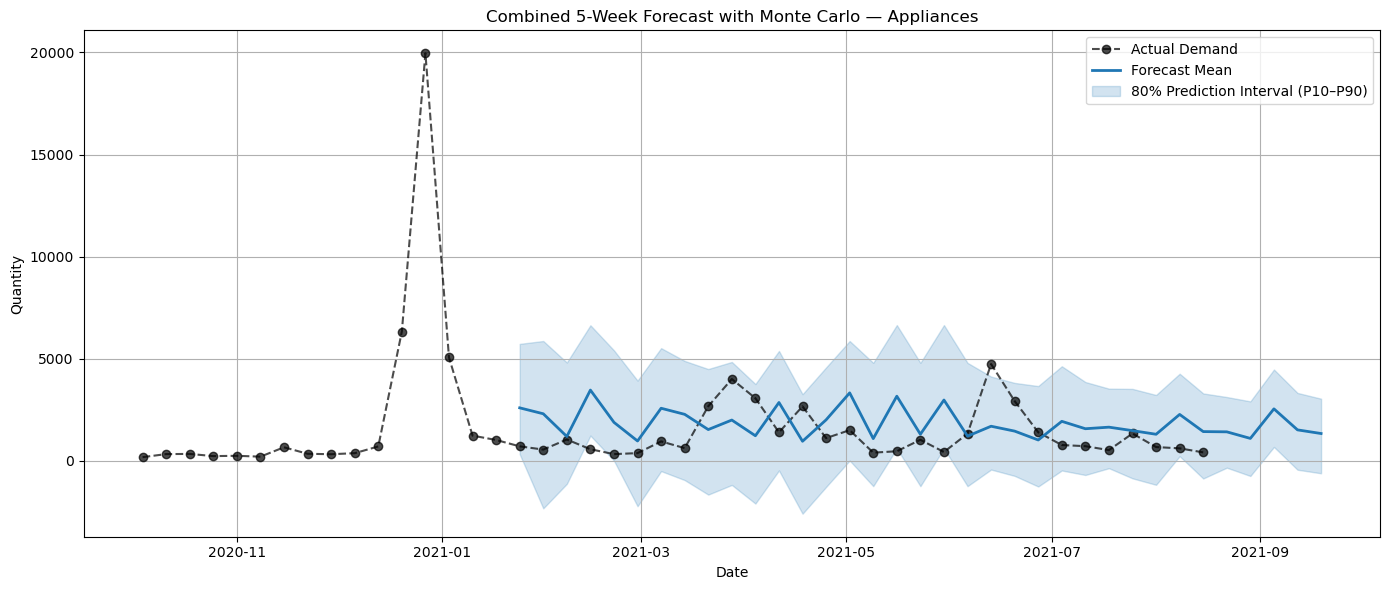


Combining and plotting all splits for: Beauty & Grooming


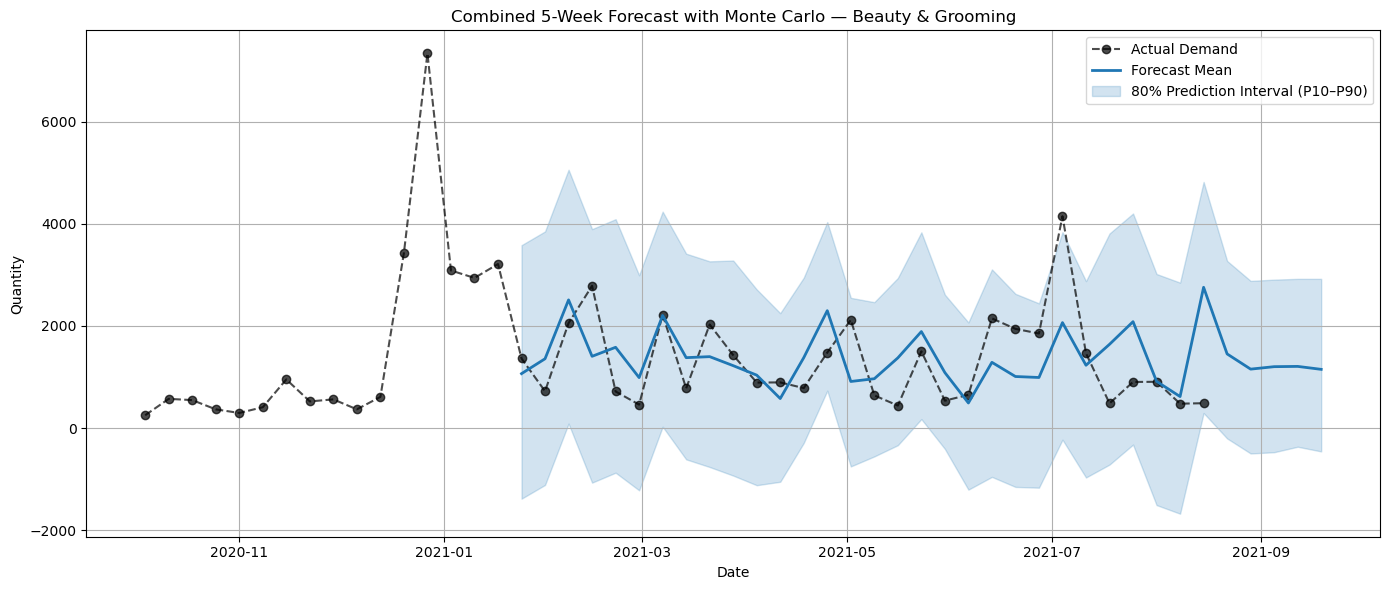


Combining and plotting all splits for: Books


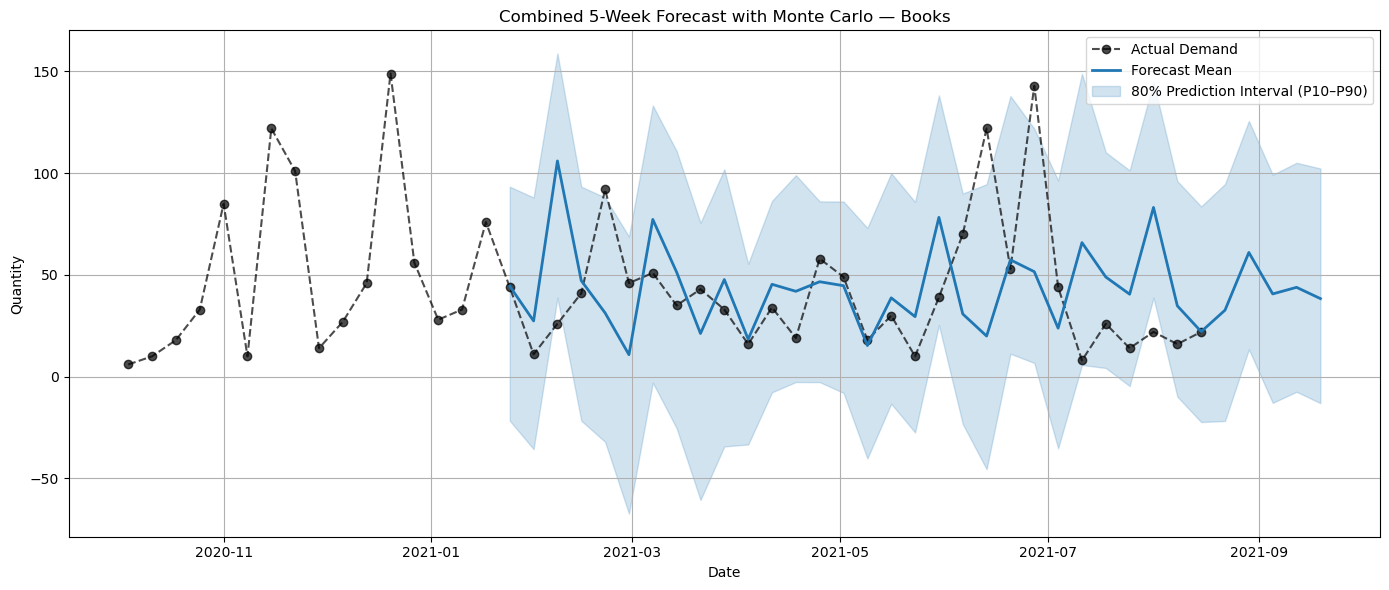


Combining and plotting all splits for: Computing


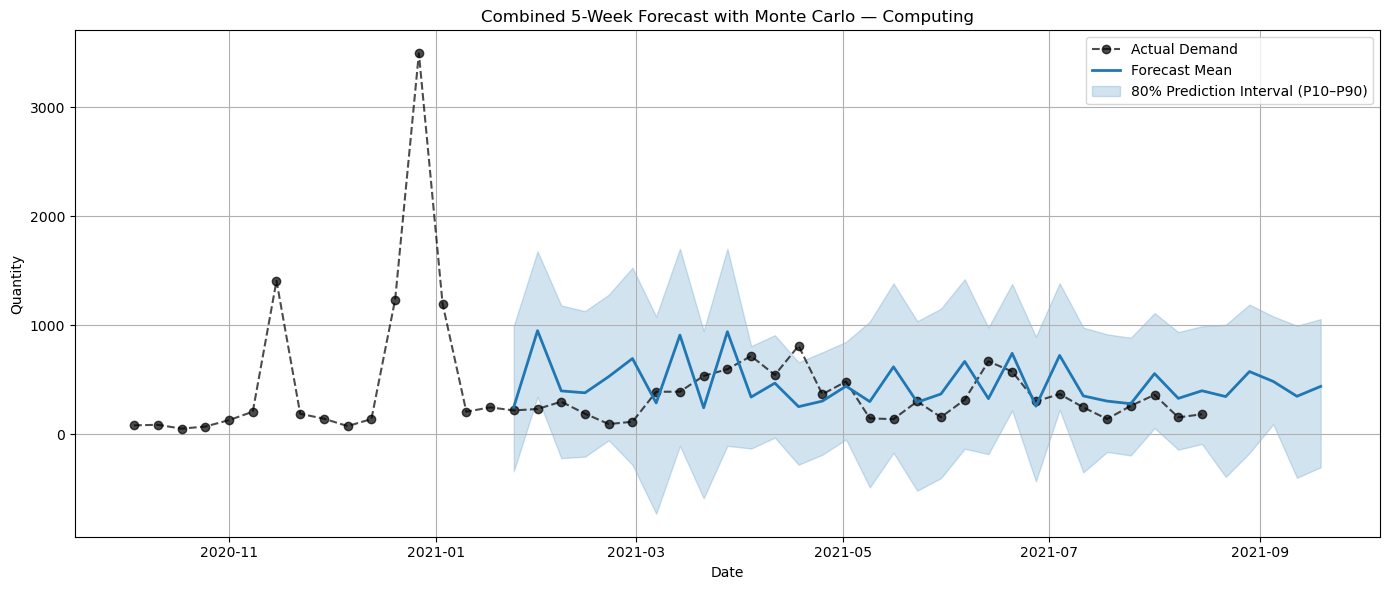


Combining and plotting all splits for: Entertainment


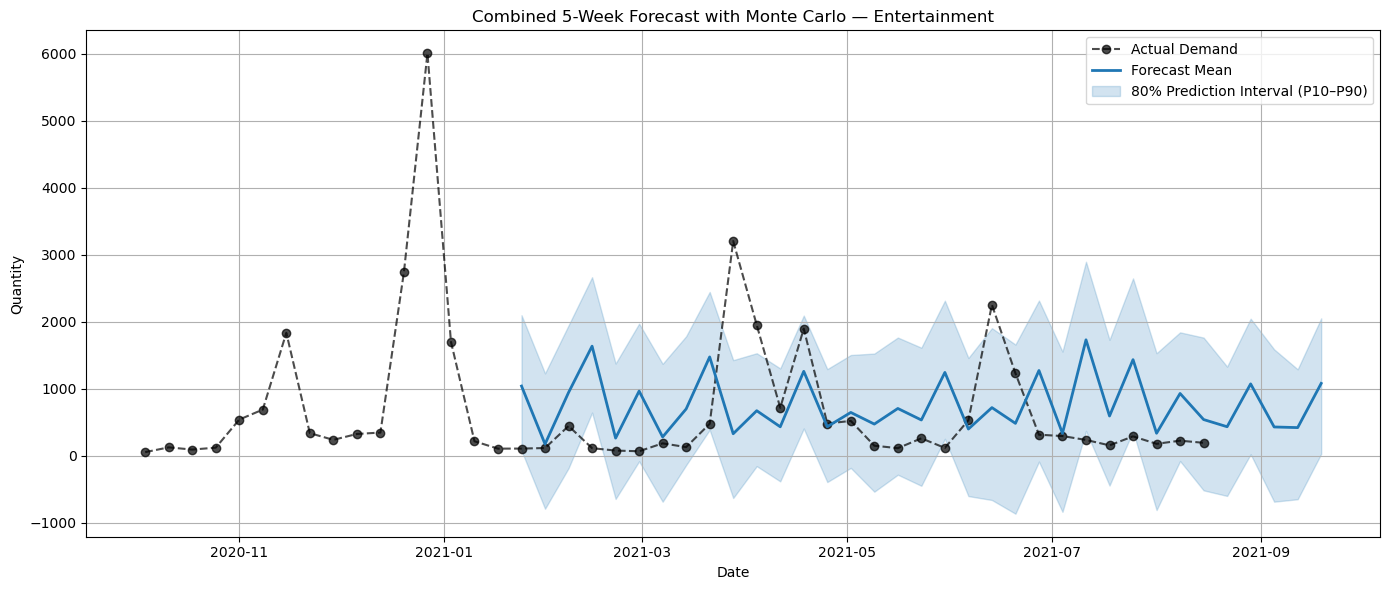


Combining and plotting all splits for: Health & Sports


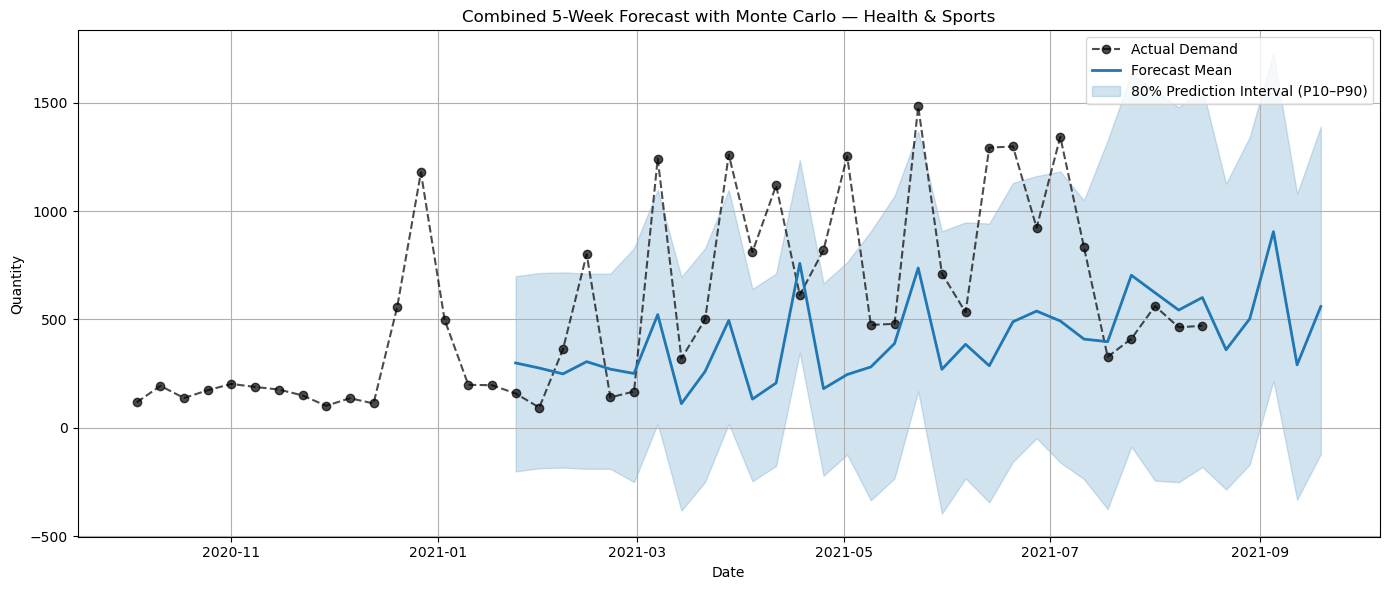


Combining and plotting all splits for: Home & Living


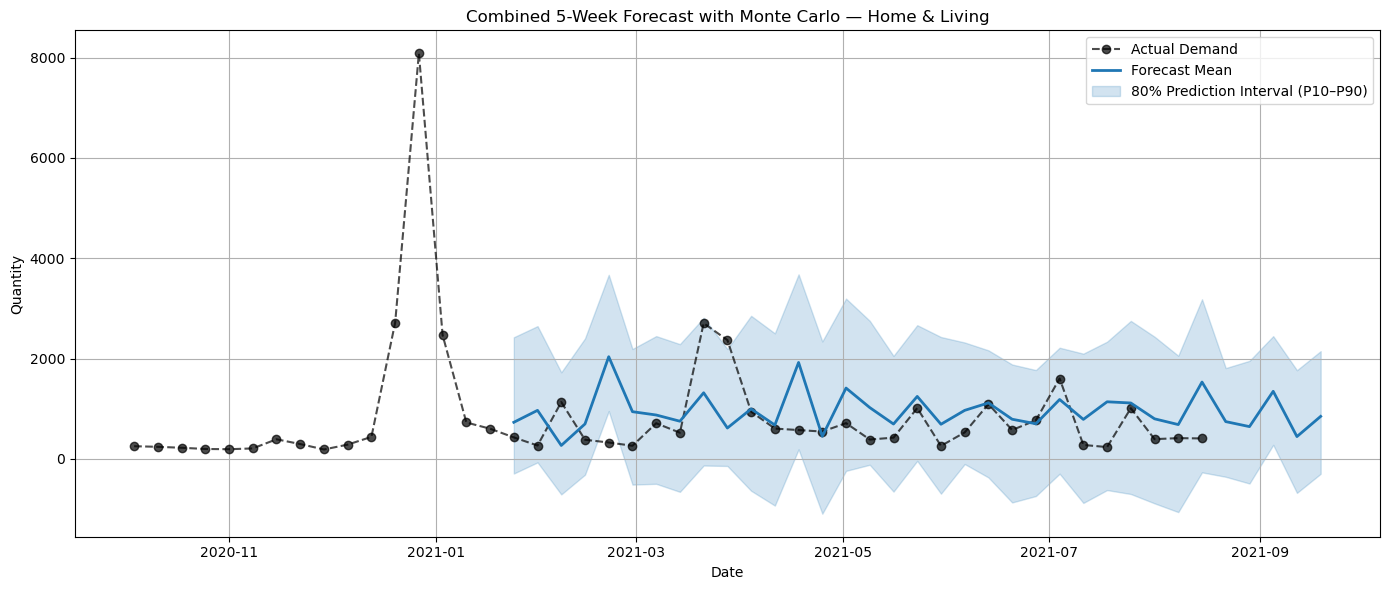


Combining and plotting all splits for: Kids & Baby


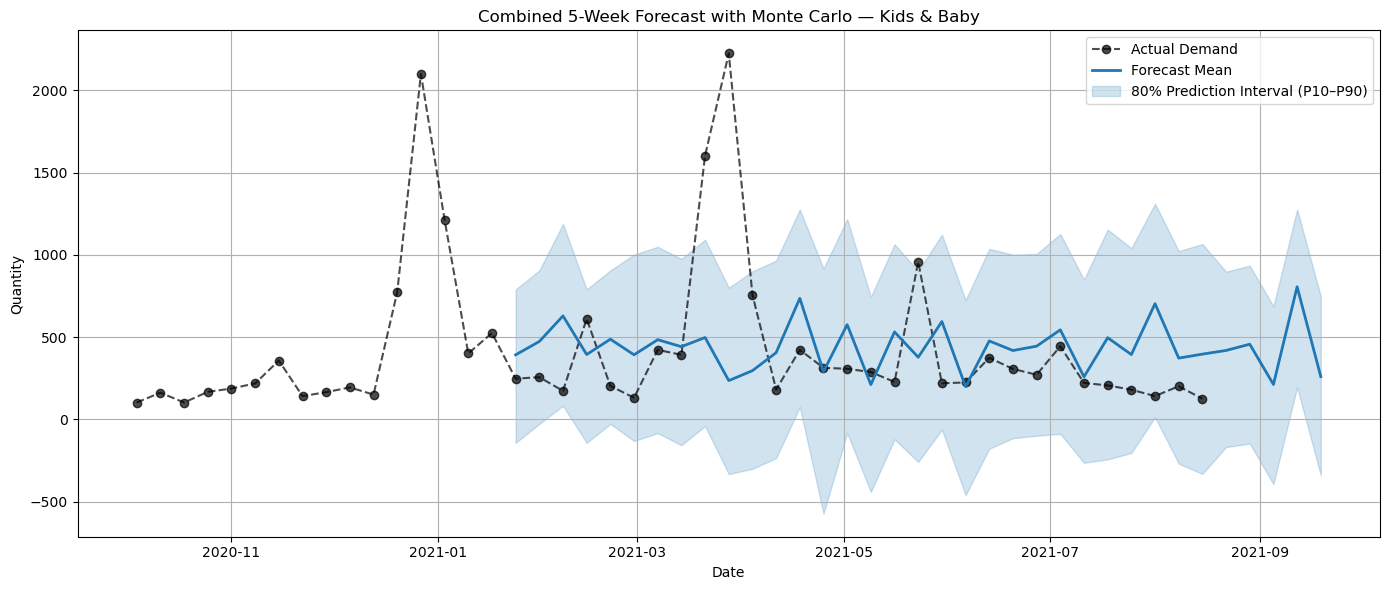


Combining and plotting all splits for: Men's Fashion


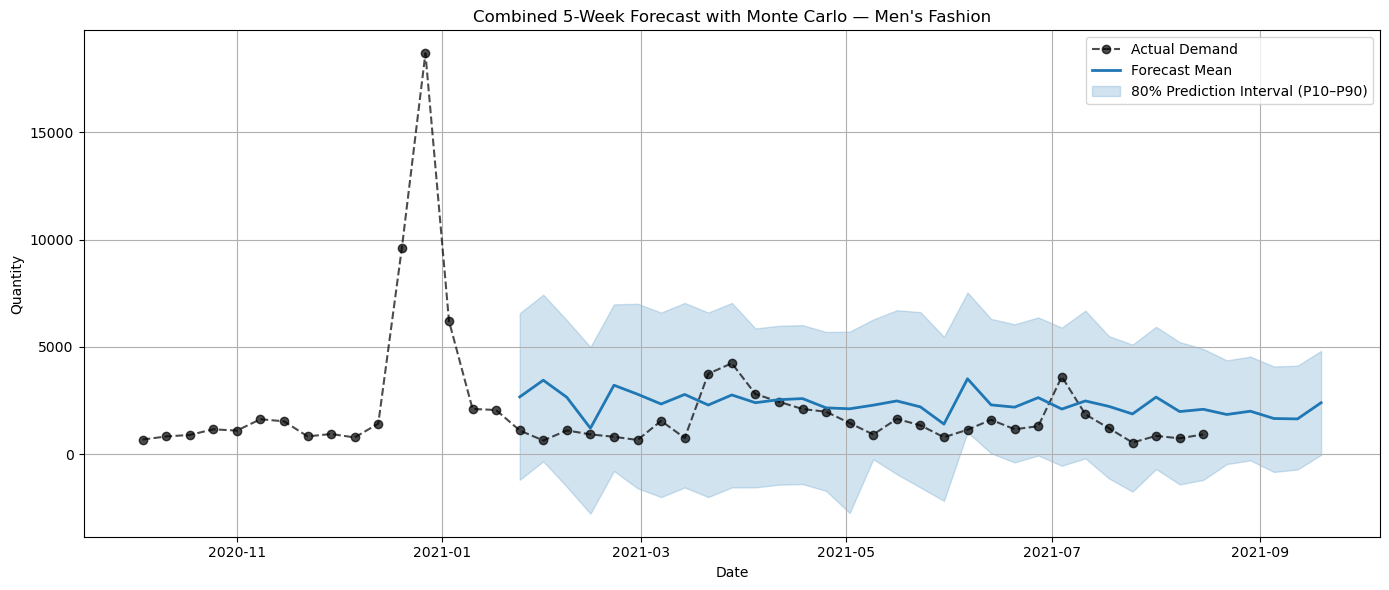


Combining and plotting all splits for: Mobiles & Tablets


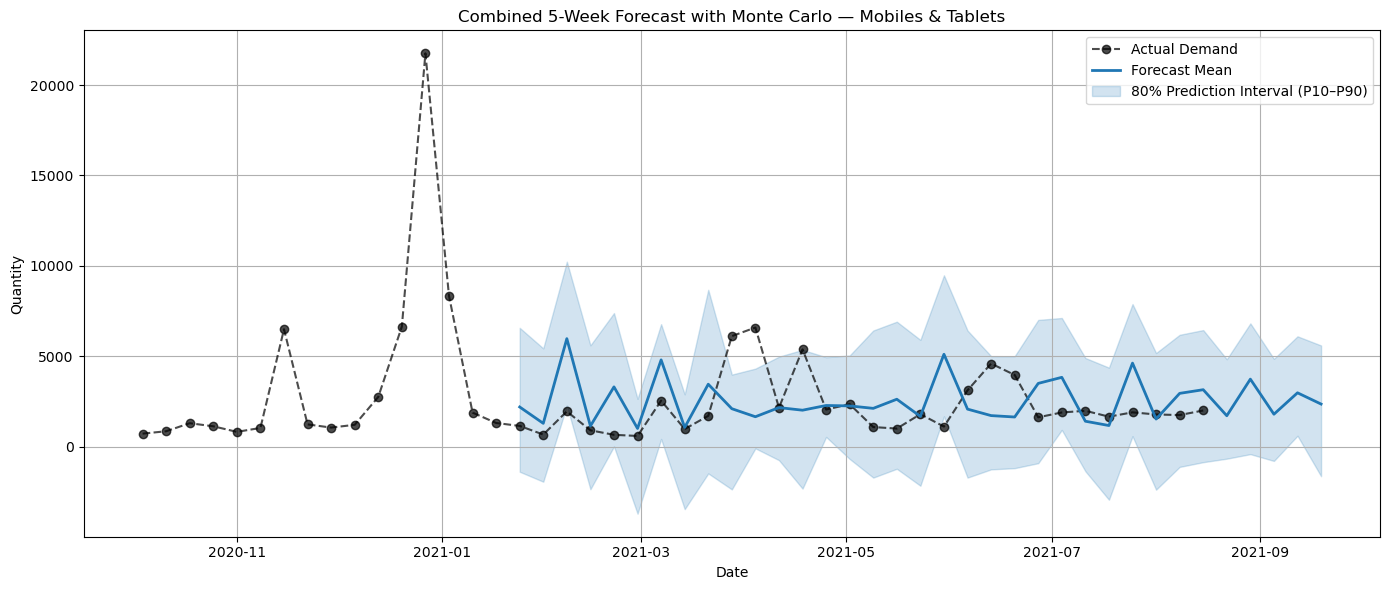


Combining and plotting all splits for: Others


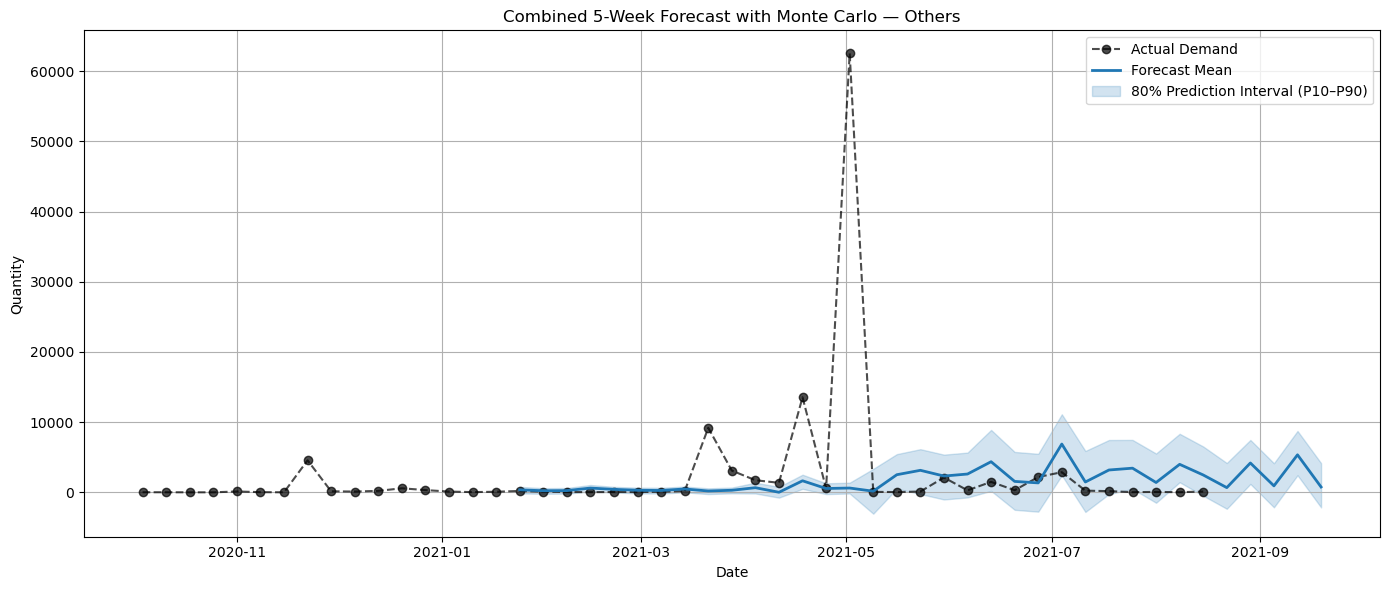


Combining and plotting all splits for: School & Education


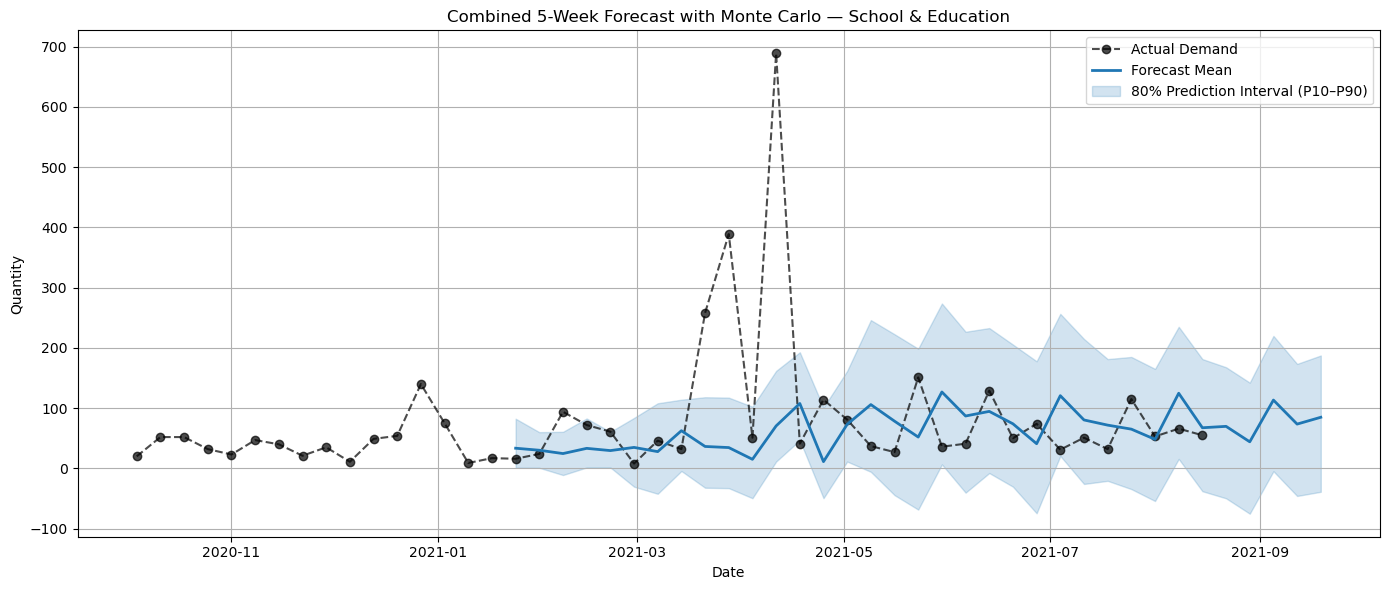


Combining and plotting all splits for: Soghaat


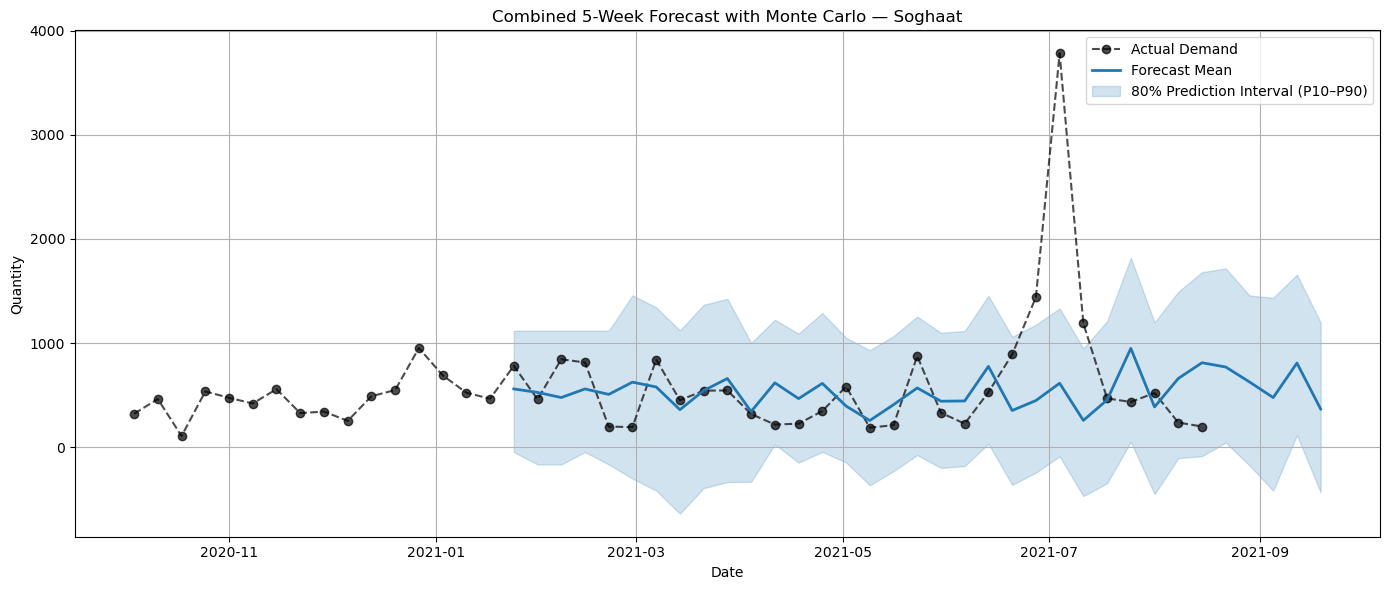


Combining and plotting all splits for: Superstore


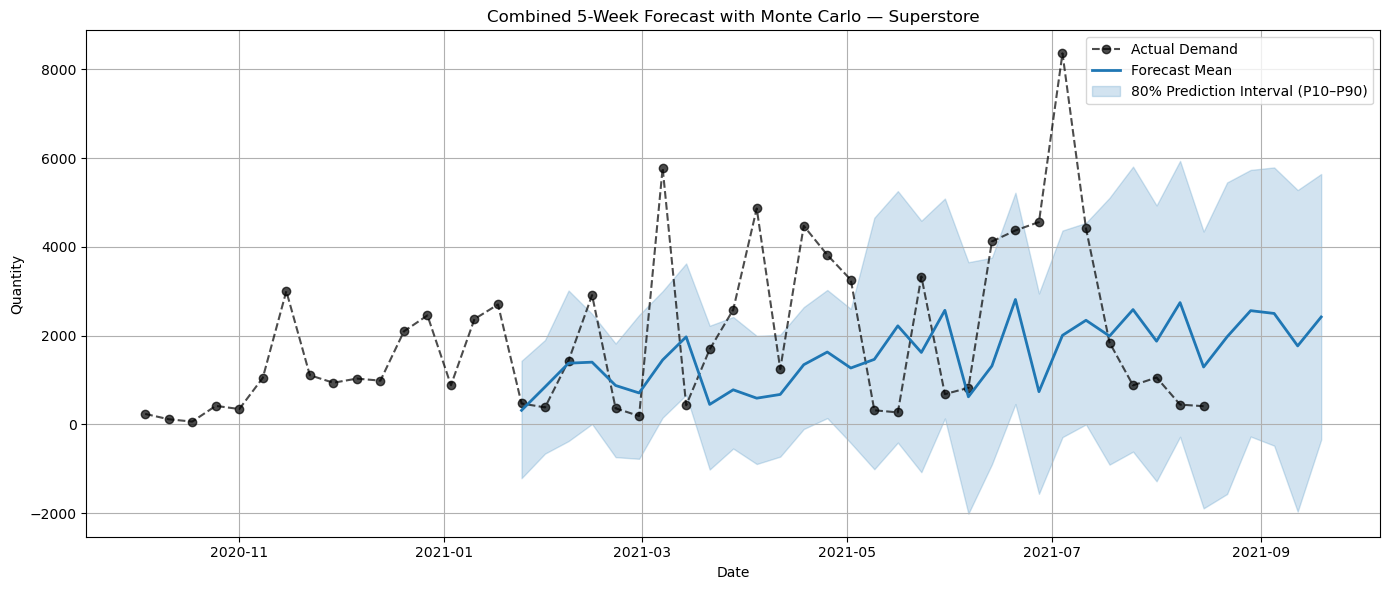


Combining and plotting all splits for: Women's Fashion


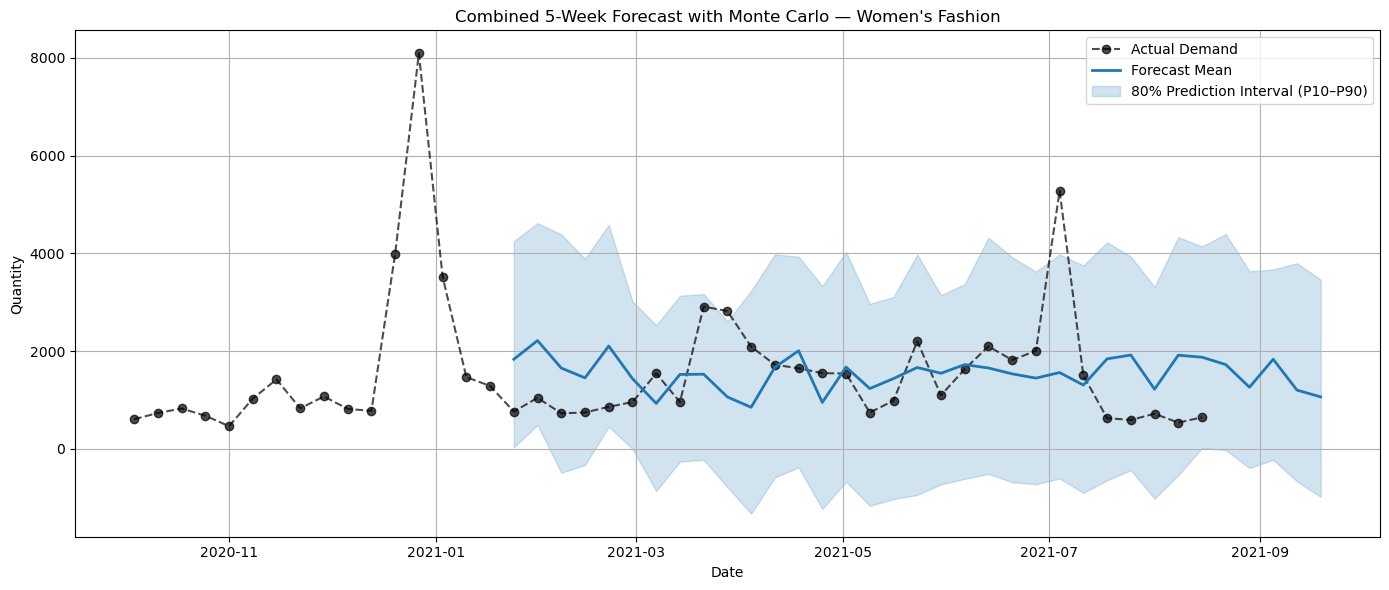

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

for cat in simulated_demands:
    print(f"\nCombining and plotting all splits for: {cat}")

    # Collect actuals and forecasts in lists
    actual_list = []
    mean_list = []
    p10_list = []
    p90_list = []

    for train_key in simulated_demands[cat]:
        if train_key not in seasonality_results[cat]:
            continue

        # === Actual demand ===
        train_df = seasonality_results[cat][train_key]["deseasonalized_train"]
        actual = train_df[["quantity"]].reset_index().rename(columns={"date": "date", "quantity": "actual"})
        actual_list.append(actual)

        # === Forecast summaries ===
        forecast_len = len(simulated_demands[cat][train_key]["forecast_mean"])
        last_actual_date = train_df.index[-1]
        forecast_dates = [last_actual_date + pd.Timedelta(weeks=i) for i in range(1, forecast_len + 1)]

        forecast_df = pd.DataFrame({
            "date": forecast_dates,
            "forecast_mean": simulated_demands[cat][train_key]["forecast_mean"],
            "p10": simulated_demands[cat][train_key]["lower_bound"],
            "p90": simulated_demands[cat][train_key]["upper_bound"]
        })
        mean_list.append(forecast_df[["date", "forecast_mean"]])
        p10_list.append(forecast_df[["date", "p10"]])
        p90_list.append(forecast_df[["date", "p90"]])

    # Combine all dataframes
    actual_df = pd.concat(actual_list, ignore_index=True)
    mean_df = pd.concat(mean_list, ignore_index=True)
    p10_df = pd.concat(p10_list, ignore_index=True)
    p90_df = pd.concat(p90_list, ignore_index=True)

    # Merge into a single dataframe
    combined_df = actual_df.merge(mean_df, on="date", how="outer") \
                           .merge(p10_df, on="date", how="outer") \
                           .merge(p90_df, on="date", how="outer")

    # Aggregate by date to remove duplicates
    combined_df = combined_df.groupby("date").agg({
        "actual": "first",
        "forecast_mean": "mean",
        "p10": "mean",
        "p90": "mean"
    }).reset_index().sort_values("date")

    # === Plot ===
    plt.figure(figsize=(14, 6))
    plt.plot(combined_df["date"], combined_df["actual"], label="Actual Demand",
             color="black", linestyle="--", marker="o", alpha=0.7)
    plt.plot(combined_df["date"], combined_df["forecast_mean"], label="Forecast Mean",
             color="tab:blue", linewidth=2)
    plt.fill_between(combined_df["date"], combined_df["p10"], combined_df["p90"],
                     color="tab:blue", alpha=0.2, label="80% Prediction Interval (P10–P90)")

    # Formatting
    plt.title(f"Combined 5-Week Forecast with Monte Carlo — {cat}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Export to Excel file 

In [12]:
import pandas as pd

export_rows = []

for cat in simulated_demands:
    print(f"Exporting results for: {cat}")

    # Full actual demand series
    actual_series = category_data[cat]["full"]["quantity"]

    for train_key in simulated_demands[cat]:
        # Last date of training data for this split
        train_df = seasonality_results[cat][train_key]["deseasonalized_train"]
        last_train_date = train_df.index[-1]

        # Forecast horizon (5 weeks)
        forecast_len = len(simulated_demands[cat][train_key]["forecast_mean"])
        forecast_dates = [last_train_date + pd.Timedelta(weeks=i) for i in range(1, forecast_len + 1)]

        # Forecast summary
        forecast_mean = simulated_demands[cat][train_key]["forecast_mean"]
        lower_bound = simulated_demands[cat][train_key]["lower_bound"]
        upper_bound = simulated_demands[cat][train_key]["upper_bound"]

        for i, date in enumerate(forecast_dates):
            export_rows.append({
                "category": cat,
                "year": date.isocalendar().year,
                "week_number": date.isocalendar().week,
                "date": date,
                "actual_quantity": actual_series.get(date, None),
                "monte_carlo_forecast": forecast_mean[i],
                "forecast_p10": lower_bound[i],
                "forecast_p90": upper_bound[i]
            })

# Build DataFrame
export_df = pd.DataFrame(export_rows)

# Sort for clarity
export_df = export_df.sort_values(by=["category", "year", "week_number"]).reset_index(drop=True)

# Export to Excel
output_file = "Amazon_MCRxML.xlsx"
export_df.to_excel(output_file, index=False)

print(f"✅ Results exported to {output_file}")


Exporting results for: Appliances
Exporting results for: Beauty & Grooming
Exporting results for: Books
Exporting results for: Computing
Exporting results for: Entertainment
Exporting results for: Health & Sports
Exporting results for: Home & Living
Exporting results for: Kids & Baby
Exporting results for: Men's Fashion
Exporting results for: Mobiles & Tablets
Exporting results for: Others
Exporting results for: School & Education
Exporting results for: Soghaat
Exporting results for: Superstore
Exporting results for: Women's Fashion
✅ Results exported to Amazon_MCRxML.xlsx


## Data Analysis Part

### Scenario Analysis

In [1]:
import pandas as pd
import numpy as np

# Load forecast output (from your simulation export)
export_df = pd.read_excel("Amazon_MCRxML.xlsx")

# Define scenarios (percentage change in demand)
scenarios = {
    "Lockdown_80": -0.80,
    "Drop_50":    -0.50,
    "Drop_30":    -0.30
}

def apply_shock(series, pct_change):
    """Apply a multiplicative demand shock to a series."""
    return series * (1 + pct_change)

scenario_results = []

for scen_name, shock_pct in scenarios.items():
    # Apply shock to actual quantities
    export_df["actual_shocked"] = apply_shock(export_df["actual_quantity"], shock_pct)
    
    # Compute metrics for shocked scenario
    coverage = np.mean(
        (export_df["actual_shocked"] >= export_df["forecast_p10"]) & 
        (export_df["actual_shocked"] <= export_df["forecast_p90"])
    )
    
    mae = np.mean(np.abs(export_df["forecast_p10"] - export_df["actual_shocked"]))
    
    scenario_results.append({
        "Scenario": scen_name,
        "Coverage_Probability": coverage,
        "MAE": mae
    })

scenario_df = pd.DataFrame(scenario_results)
print(scenario_df)


      Scenario  Coverage_Probability          MAE
0  Lockdown_80              0.893333   743.803262
1      Drop_50              0.904762  1042.201108
2      Drop_30              0.899048  1248.638567


### Coverage Probability

In [2]:
# Coverage Probability in original forecast
coverage_prob = np.mean(
    (export_df["actual_quantity"] >= export_df["forecast_p10"]) & 
    (export_df["actual_quantity"] <= export_df["forecast_p90"])
)
print(f"Coverage Probability (Base Case): {coverage_prob:.2%}")


Coverage Probability (Base Case): 84.38%


### Business Savings Estimation

In [11]:
import pandas as pd
import numpy as np

# Load your forecast export (from your Monte Carlo run)
export_df = pd.read_excel("Amazon_MCRxML.xlsx")
export_df.columns = export_df.columns.str.lower()

# Assumed unit price per category — updated to match YOUR categories exactly
ASSUMED_PRICE = {
    "Appliances": 180.0,
    "Beauty & Grooming": 20.0,
    "Books": 15.0,
    "Computing": 250.0,
    "Entertainment": 25.0,
    "Health & Sports": 50.0,
    "Home & Living": 60.0,
    "Kids & Baby": 35.0,
    "Men's Fashion": 45.0,
    "Mobiles & Tablets": 400.0,
    "Others": 30.0,
    "School & Education": 20.0,
    "Soghaat": 80.0,
    "Superstore": 40.0,
    "Women's Fashion": 55.0,
}

# Fallback price if any category is missing
FALLBACK_PRICE = 30.0

# Map unit prices
export_df["unit_price"] = export_df["category"].map(ASSUMED_PRICE).fillna(FALLBACK_PRICE)

# Keep only the fields we need
base = export_df.dropna(subset=["actual_quantity", "monte_carlo_forecast", "forecast_p10", "forecast_p90"]).copy()

# Define cost parameters
holding_cost_per_unit = 2.0   # cost of holding one unit in stock
stockout_cost_per_unit = 5.0  # penalty for not having enough stock

# Calculate over-forecast (overstock) and under-forecast (stockout)
base["overstock_units"] = np.where(base["monte_carlo_forecast"] > base["actual_quantity"],
                                   base["monte_carlo_forecast"] - base["actual_quantity"], 0)
base["stockout_units"] = np.where(base["monte_carlo_forecast"] < base["actual_quantity"],
                                  base["actual_quantity"] - base["monte_carlo_forecast"], 0)

# Costs in monetary terms
base["overstock_cost"] = base["overstock_units"] * holding_cost_per_unit
base["stockout_cost"] = base["stockout_units"] * stockout_cost_per_unit

# Revenue potential if forecast matches actual demand exactly
base["revenue_if_perfect"] = base["actual_quantity"] * base["unit_price"]

# Revenue loss from stockouts
base["lost_revenue_from_stockouts"] = base["stockout_units"] * base["unit_price"]

# Total potential savings = avoiding stockouts + avoiding overstock costs
total_savings = base["overstock_cost"].sum() + base["lost_revenue_from_stockouts"].sum()

print("=== Business Savings Estimation ===")
print(f"Total Overstock Cost: ${base['overstock_cost'].sum():,.2f}")
print(f"Total Stockout Cost (in penalties): ${base['stockout_cost'].sum():,.2f}")
print(f"Total Lost Revenue from Stockouts: ${base['lost_revenue_from_stockouts'].sum():,.2f}")
print(f"Estimated Potential Savings: ${total_savings:,.2f}")


=== Business Savings Estimation ===
Total Overstock Cost: $494,702.44
Total Stockout Cost (in penalties): $1,184,806.77
Total Lost Revenue from Stockouts: $18,750,308.45
Estimated Potential Savings: $19,245,010.90


### Savings Breakdown Pie Chart

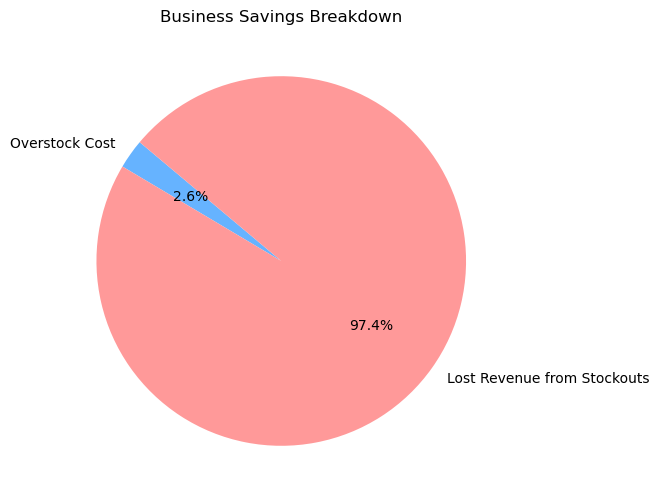

In [12]:
import matplotlib.pyplot as plt

cost_breakdown = {
    "Overstock Cost": base["overstock_cost"].sum(),
    "Lost Revenue from Stockouts": base["lost_revenue_from_stockouts"].sum()
}

plt.figure(figsize=(6,6))
plt.pie(cost_breakdown.values(), labels=cost_breakdown.keys(),
        autopct='%1.1f%%', startangle=140, colors=["#66b3ff", "#ff9999"])
plt.title("Business Savings Breakdown")
plt.show()


### Category-Wise Savings Bar Chart

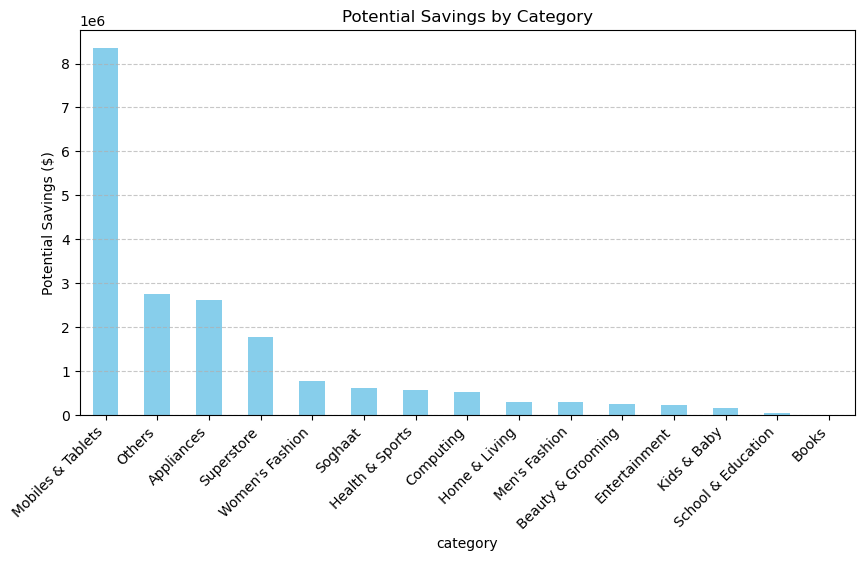

In [13]:
category_savings = base.groupby("category").apply(
    lambda x: x["overstock_cost"].sum() + x["lost_revenue_from_stockouts"].sum()
).sort_values(ascending=False)

plt.figure(figsize=(10,5))
category_savings.plot(kind="bar", color="skyblue")
plt.ylabel("Potential Savings ($)")
plt.title("Potential Savings by Category")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
